In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [24]:
data = pd.read_csv("csv files/demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


In [25]:
print(data.describe())
data.shape

       Unnamed: 0      Demand    Inventory
count   62.000000   62.000000    62.000000
mean    30.500000  120.709677  2073.822581
std     18.041619   44.852906  1840.782144
min      0.000000   51.000000     0.000000
25%     15.250000   85.000000    25.500000
50%     30.500000  124.000000  1908.000000
75%     45.750000  152.750000  3594.250000
max     61.000000  199.000000  5500.000000


(62, 5)

In [26]:
data = data.drop(columns=['Unnamed: 0'])

In [27]:
fig_demand = px.line(data, x='Date',
                     y='Demand',
                     title='Demand Over Time')
fig_demand.show()

In [28]:
fig_inventory = px.line(data, x='Date',
                        y='Inventory',
                        title='Inventory Over Time')
fig_inventory.show()

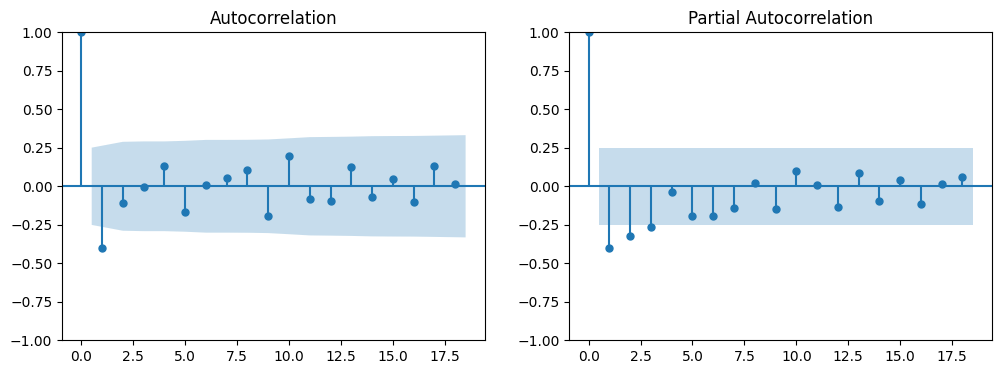

In [31]:
data['Date'] = pd.to_datetime(data['Date'],
                             format='%Y-%m-%d')
time_series = data.set_index('Date')['Demand']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

plt.show()

In [32]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int64


In [37]:


# === Forecasted Demand Preparation ===
# future_steps: number of days to forecast (e.g., 10)
# predictions: your SARIMA model predictions as a NumPy array or Series
future_dates = pd.date_range(
    start=time_series.index[-1] + pd.DateOffset(days=1),
    periods=future_steps,
    freq='D'
)

forecasted_demand = pd.Series(predictions, index=future_dates)

# === Inventory and Policy Parameters ===
initial_inventory = 5500       # current inventory on hand
lead_time = 1                  # lead time in days (adjust per business)
service_level = 0.95           # target service level (95%)

# === Order Quantity Using Newsvendor Formula ===
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = int(np.ceil(forecasted_demand.mean() + z))

# === Reorder Point and Safety Stock ===
reorder_point = forecasted_demand.mean() * lead_time + z
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# === Cost Parameters ===
holding_cost = 0.1             # holding cost per unit
stockout_cost = 10             # stockout cost per unit

total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * max(0, forecasted_demand.mean() * lead_time - initial_inventory)
total_cost = total_holding_cost + total_stockout_cost

# === Print Outputs ===
print(f"Optimal Order Quantity: {order_quantity}")
print(f"Reorder Point: {reorder_point:.2f}")
print(f"Safety Stock: {safety_stock:.2f}")
print(f"Total Cost: {total_cost:.2f}")


Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.80
